# Pulse Shaping

This chapter covers pulse shaping, inter-symbol-interference, matched filtering, and raised-cosine filters. At the end we use Python to add pulse shaping to BPSK symbols. You can consider this section Part II of the Filters chapter, where we take a deeper dive into pulse shaping.

# Inter-Symbol-Interference (ISI)

In the Filters chapter we learned that blocky-shaped symbols/pulses use an excess amount of spectrum, and we can greatly reduce the amount of spectrum used by “shaping” our pulses. However, you can’t use just any low-pass filter or you might get inter-symbol-interference (ISI), where symbols bleed into and interfere with each other.

When we transmit digital symbols, we transmit them back-to-back (as opposed to waiting some time between them). When you apply a pulse-shaping filter, it elongates the pulse in the time domain (in order to condense it in frequency), which causes adjacent symbols to overlap with each other. The overlap is fine, as long as your pulse-shaping filter meets this one criterion: all of the pulses must add up to zero at every multiple of our symbol period T, except for one of the pulses. The idea is best understood through the following visualization:

![Alt text](https://pysdr.org/_images/pulse_train.svg)

As you can see at every interval of T, there is one peak of a pulse while rest of the pulses are at 0 (they cross the x-axis). When the receiver samples the signal, it does so at the perfect time (at the peak of the pulses), meaning that is the only point in time which matters. Usually there is a symbol synchronization block at the receiver that ensures the symbols are sampled at the peaks.

# Matched Filter

One trick we use in wireless communications is called matched filtering. To understand matched filtering you must first understand these two points:

1. The pulses we discussed above only have to be aligned perfectly at the receiver prior to sampling. Until that point it doesn’t really matter if there is ISI, i.e., the signals can fly through the air with ISI and it’s OK.

2. We want a low-pass filter in our transmitter to reduce the amount of spectrum our signal uses. But the receiver also needs a low-pass filter to eliminate as much noise/interference next to the signal as possible. As a result, we have a low-pass filter at the transmitter (Tx) and another at the receiver (Rx), then sampling occurs after both filters (and the wireless channel’s effects).

What we do in modern communications is split the pulse shaping filter equally between the Tx and Rx. They don’t have to be identical filters, but, theoretically, the optimal linear filter for maximizing the SNR in the presence of AWGN is to use the same filter at both the Tx and Rx. This strategy is called the “matched filter” concept.

# Splitting a Filter in Half

To split a filter in half you can take the square root of the frequency response.

![Alt text](https://pysdr.org/_images/math/7e7d6f2cb6946f45a7252e5229da937c2571556b.svg)

Below shows a simplified diagram of a transmit and receive chain, with a Raised Cosine (RC) filter being split into two Root Raised Cosine (RRC) filters; the one on the transmit side is the pulse shaping filter, and the one on the received side is the matched filter. Together, they cause the pulses at the demodulator to appear as if they had been pulse shaped with a single RRC filter.

![Alt text](https://pysdr.org/_images/splitting_rc_filter.svg)

We know that we want to:

1. Design a filter that reduces the bandwidth of our signal (to use less spectrum) and all pulses except one should sum to zero every symbol interval.

2. Split the filter in half, putting one half in the Tx and the other in the Rx.
Let’s look at some specific filters that are common to use for pulse-shaping.

# Raised-Cosine Filter

The most popular pulse-shaping filter seems to be the “raised-cosine” filter. It’s a good low-pass filter for limiting the bandwidth our signal will occupy, and it also has the property of summing to zero at intervals of T:

![Alt text](https://pysdr.org/_images/raised_cosine.svg)

Note that the above plot is in the time domain. It depicts the impulse response of the filter. The \beta parameter is the only parameter for the raised-cosine filter, and it determines how quickly the filter tapers off in the time domain, which will be inversely proportional with how quickly it tapers off in frequency:

![Alt text](https://pysdr.org/_images/raised_cosine_freq.svg)

The reason it’s called the raised-cosine filter is because the frequency domain when \beta = 1 is a half-cycle of a cosine wave, raised up to sit on the x-axis.

The equation that defines the impulse response of the raised-cosine filter is:

![Alt text](<Screenshot 2024-01-12 154821.png>)

Remember: we split this filter between the Tx and Rx equally. Enter the Root Raised Cosine (RRC) Filter!

# Root Raised-Cosine Filter

The root raised-cosine (RRC) filter is what we actually implement in our Tx and Rx. Combined they form a normal raised-cosine filter, as we discussed. Because splitting a filter in half involves a frequency-domain square root, the impulse response gets a bit messy:

![Alt text](https://pysdr.org/_images/rrc_filter.png)

Luckily it’s a heavily used filter and there are plenty of implementations, including in Python.

# Python Exercise

As a Python exercise let’s filter and shape some pulses. We will use BPSK symbols so that it’s easier to visualize–prior to the pulse-shaping step, BPSK involves transmitting 1’s or -1’s with the “Q” portion equal to zero. With Q equal to zero we can plot the I portion only, and it’s easier to look at.

In this simulation we will use 8 samples per symbol, and instead of using a square-wave looking signal of 1’s and -1’s, we use a pulse train of impulses. When you put an impulse through a filter, the output is the impulse response (hence the name). Therefore if you want a series of pulses, you want to use impulses with zeros in between to avoid square pulses.

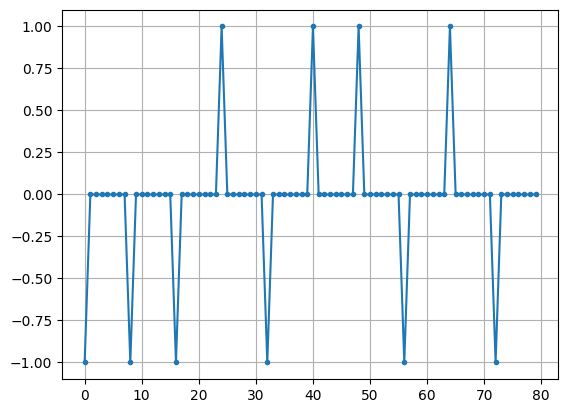

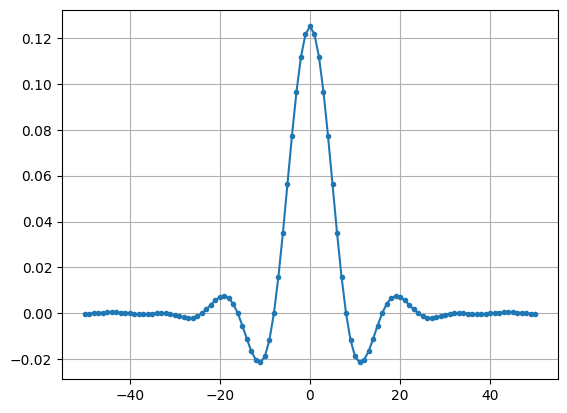

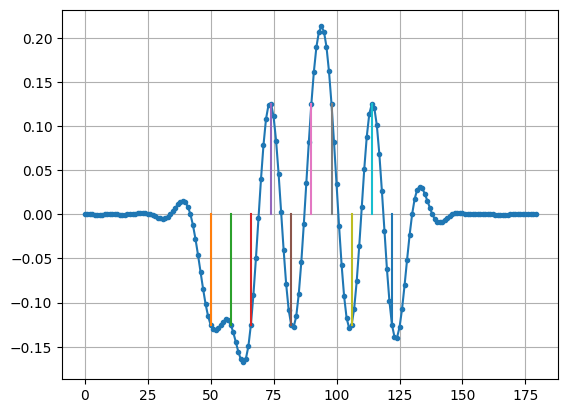

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig

num_symbols = 10
sps = 8

bits = np.random.randint(0,2, num_symbols)

x = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1
    x = np.hstack((x, pulse))

plt.figure(0)
plt.plot(x, '.-')
plt.grid(True)
plt.show()

# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(num_taps) - (num_taps-1)//2
h = 1/Ts*np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)
plt.figure(1)
plt.plot(t, h, '.-')
plt.grid(True)
plt.show()

# Filter our signal, in order to apply the pulse shaping
x_shaped = np.convolve(x, h)
plt.figure(2)
plt.plot(x_shaped, '.-')
for i in range(num_symbols):
    plt.plot([i*sps+num_taps//2,i*sps+num_taps//2], [0, x_shaped[i*sps+num_taps//2]])
plt.grid(True)
plt.show()
